<img src='img/fastcamp_h.png' height=100% width=100%>

# 12강. Segmentation and Colorization

# 이번장에서 배우는 것들
* segmentation
  * fcn (Fully Convolutional Network)
  * U-Net
* colorization
 * concepts

# FCN (fully convolutional network)

### Motivation
* 보통 CNN의 구조는 Encoder와 닮아 있음
* 주어진 이미지를 conv연산과 pooling 연산을 하면서 더 작고 긴 vector를 생성
* 최종적으로 dense vector를 생성한 후 원하는 테스크에 맞는 출력 layer를 구축함
* fcn의 저자는 dense vector의 생성을 아예 없애고 conv 동작만으로 아주 작게 줄인 ?x?xc 벡터를 다시 확장하면 어떨까 하는 생각을 함

<img src='img/12_01.png' height=100% width=100%>

In [1]:
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, ReLU, BatchNormalization, Dropout
from keras.models import Model

def vgg16_fcn32():
    inputs = Input(shape=(224, 224, 3))
    x = Conv2D(64, 3, activation='relu', padding='same', trainable=False)(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same', trainable=False)(x)
    x = MaxPool2D(2, 2, trainable=False)(x)
    
    x = Conv2D(128, 3, activation='relu', padding='same', trainable=False)(x)
    x = Conv2D(128, 3, activation='relu', padding='same', trainable=False)(x)
    x = MaxPool2D(2, 2, trainable=False)(x)
    
    x = Conv2D(256, 3, activation='relu', padding='same', trainable=False)(x)
    x = Conv2D(256, 3, activation='relu', padding='same', trainable=False)(x)
    x = Conv2D(256, 3, activation='relu', padding='same', trainable=False)(x)
    x = MaxPool2D(2, 2, trainable=False)(x)
    
    x = Conv2D(512, 3, activation='relu', padding='same', trainable=False)(x)
    x = Conv2D(512, 3, activation='relu', padding='same', trainable=False)(x)
    x = Conv2D(512, 3, activation='relu', padding='same', trainable=False)(x)
    x = MaxPool2D(2, 2, trainable=False)(x)
    
    x = Conv2D(512, 3, activation='relu', padding='same', trainable=False)(x)
    x = Conv2D(512, 3, activation='relu', padding='same', trainable=False)(x)
    x = Conv2D(512, 3, activation='relu', padding='same', trainable=False)(x)
    x = MaxPool2D(2, 2, trainable=False)(x)
    
    vgg16 = Model(inputs, x)
    vgg16.load_weights('C:/Users/sons/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    # fc
    x = Conv2D(1024, 7, activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    
    x = Conv2D(1024, 1, activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    
    
    
    x = Conv2D(3, 1, activation='sigmoid', padding='same')(x)
    x = UpSampling2D(size=(32, 32))(x)
    return Model(inputs, x)
    
model = vgg16_fcn32()
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [2]:
import imageio
import glob
import numpy as np
import random
X = []
Y = []

images = glob.glob('data/oxford-pet/small/images/*.jpg')
random.shuffle(images)
for path in images:
    X.append(imageio.imread(path))    
    
    path = path.replace('images', 'annotations').replace('.jpg', '.png')
    y = imageio.imread(path, as_gray=True)
    cls = 1 #고양이
    
    if path.split('\\')[-1][0].islower():
        cls = 2 # 강아지
    
    y[y != 0] = cls
    Y.append(y)
    
X = np.array(X)
Y = np.array(Y)

In [3]:
X.shape, Y.shape

((1129, 224, 224, 3), (1129, 224, 224))

In [4]:
print(np.unique(Y[0]))
print(np.unique(Y[23]))

[0. 1.]
[0. 2.]


In [5]:
import matplotlib.pylab as plt
def show(x, y, norm=False):
    mask = np.repeat(np.expand_dims(y, axis=-1), 3, axis=-1).astype(np.int32)
    mask[mask != 0] += 250
    
    if norm:
        x = (x + 1.) * 127.5
        x = x.astype(np.int32)
    plt.imshow(np.hstack([x, mask]))
    plt.show() 

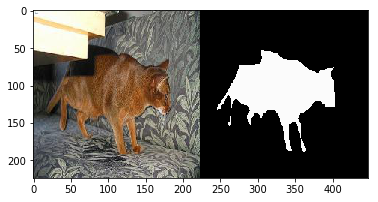

In [6]:
show(X[0], Y[0])

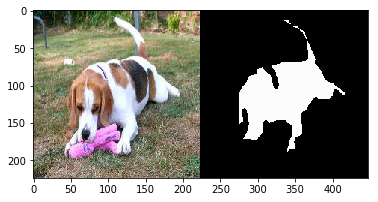

In [7]:
show(X[23], Y[23])

In [8]:
split = int(len(X) * 0.1)
train_x = X[:-split] / 127.5 - 1.
train_y = Y[:-split]

test_x = X[-split:] / 127.5 - 1.
test_y = Y[-split:]

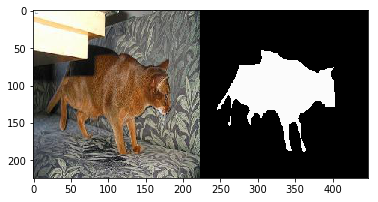

In [9]:
show(train_x[0], train_y[0], True)

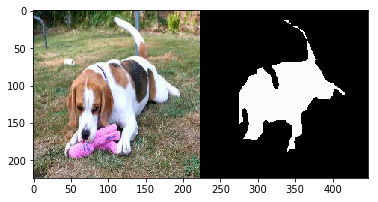

In [10]:
show(train_x[23], train_y[23], True)

### sementic segmentation의 출력

* 현재의 y는 다음과 같은 모습임
* 조금 더 쉬운 연산을 위하여 onehot encoding으로 변경
<center><img src='img/11_13.png' height=100% width=100%></center>

In [11]:
def onehot_encoding(mask, classes=[0, 1,2]):
    onehot_map = []
    for cls in classes:
        class_map = np.equal(mask, cls)
        onehot_map.append(class_map)
    onehot_map = np.stack(onehot_map, axis=-1)
    return onehot_map.astype(np.float32)

In [12]:
train_y2 = np.array([onehot_encoding(mask) for mask in train_y])
test_y2 = np.array([onehot_encoding(mask) for mask in test_y])

In [13]:
train_y.shape, train_y2.shape, test_y.shape, test_y2.shape

((1017, 224, 224), (1017, 224, 224, 3), (112, 224, 224), (112, 224, 224, 3))

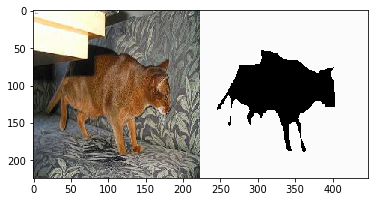

In [14]:
show(train_x[0], train_y2[0][...,0], True)

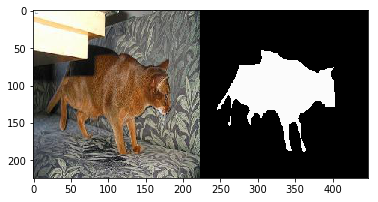

In [15]:
show(train_x[0], train_y2[0][...,1], True)

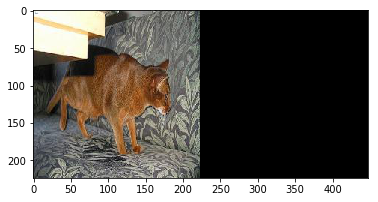

In [16]:
show(train_x[0], train_y2[0][...,2], True)

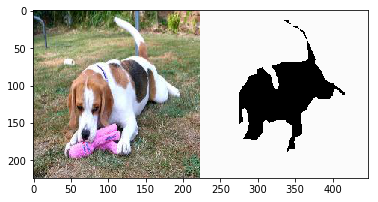

In [17]:
show(train_x[23], train_y2[23][...,0], True)

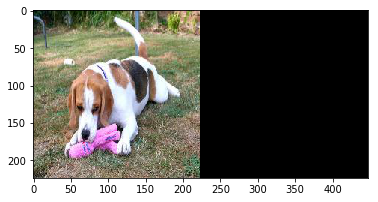

In [18]:
show(train_x[23], train_y2[23][...,1], True)

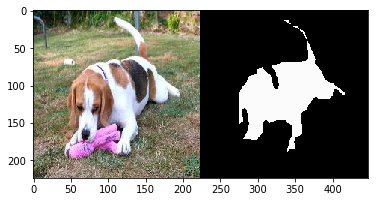

In [19]:
show(train_x[23], train_y2[23][...,2], True)

### one-hot encoding

* 출력은 다음과 같은 형태로 변경 된것을 확인 할 수 있음

<center><img src='img/11_14.png' height=100% width=100%></center>

In [20]:
model.fit(train_x, train_y2, validation_data=(test_x, test_y2), epochs=15, batch_size=1)

Instructions for updating:
Use tf.cast instead.
Train on 1017 samples, validate on 112 samples
Epoch 1/15
1017/1017 [==============================] - 140s 138ms/step - loss: 2.8983 - val_loss: 2.9951
Epoch 2/15
 371/1017 [=========>....................] - ETA: 1:24 - loss: 2.7762

KeyboardInterrupt: 

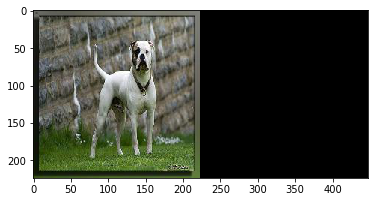

In [26]:
pred = model.predict( np.expand_dims (train_x[23],axis=0 ))

show(train_x[23], pred[0][...,2], True)
     

# deep Jet

* fcn의 저자는 최종 latent vector에서 32배 확대한 segmentation은 detail이 부족하다고 생각
* 해당 detail을 채우기 위하여 down sampling 하는 과정상의 결과를 up sampling에 합쳐주면 어떨까하는 생각을 함
* 해당 구조는 resnet의 kip connection과 아이디어를 완전히 공유함

<center><img src='img/12_02.png' height=100% width=100%></center>

# FCN의 deep jet 횟수 당 결과

* fcn 32는 skip connection을 한번도 적용하지 않은 결과
* fcn 16은 skip connection을 한번 적용한 결과
* fcn 8은 skip connection을 두번 적용한 결과
* 실제로 skip connection을 적용하면 작은 detail을 맞추는 것을 보임

<center><img src='img/12_03.png' height=100% width=100%></center>

# U-Net

### Motivation
* U-net은 resnet과 fcn에 강한 연관이 있음
* 모든 down sampling과 up sampling을 연결한다면 해상도가 증가하지 않을까? 라는 물음에 대한 결과물
* U-net은 다음과 같은 형태임
* unet은 의료 분야에서 세포와 세포간의 경계를 구분하기 위하여 설계됨
* 경계를 더 잘 구분하는 loss등이 설계되어 있음

<img src='img/12_04.png' height=70% width=70%>

# portrait segmentation

* semantic segmentation의 응용 기술
* 여러클래스가 아닌 배경과 사람만을 구분하는 기술
* 다음과 snow에 deep learning 기술을 납품하고 있는 날비라는 회사의 portrait segmentation 기술
* 사람 주변의 배경은 없애고 edge에는 특수한 이펙트를 삽입
<center><img src='img/12_06.png' height=30% width=30%></center>

# unet을 이용한 portrait segmentation

* 다음과 같은 얼굴 학습셋이 주어짐
* 사람의 상반신 사진과, 그것에 픽셀 단위의 mask가 된 정답셋이 주어짐
* 정답셋은 경계구분이 정확하지 않은 데이터들도 꽤 존재함
<img src='img/12_05.png' height=70% width=70%>

In [49]:
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, ReLU, BatchNormalization, Dropout, Activation, Conv2DTranspose, concatenate
from keras.models import Model
from keras.optimizers import Adam

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, kernel_initializer="he_normal", padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(channel, 3, kernel_initializer="he_normal", padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_like():
    inputs = Input((224, 224, 3))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2, 2)) (c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2, 2)) (c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2, 2)) (c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 3, strides=2, padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 3, strides=2, padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 3, strides=2, padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 3, strides=2, padding='same') (c8)
    #u9 = concatenate([u9, c1], axis=3)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [50]:
unet = unet_like()
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 224, 224, 16) 448         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 224, 224, 16) 64          conv2d_82[0][0]                  
__________________________________________________________________________________________________
activation_63 (Activation)      (None, 224, 224, 16) 0           batch_normalization_64[0][0]     
__________________________________________________________________________________________________
conv2d_83 

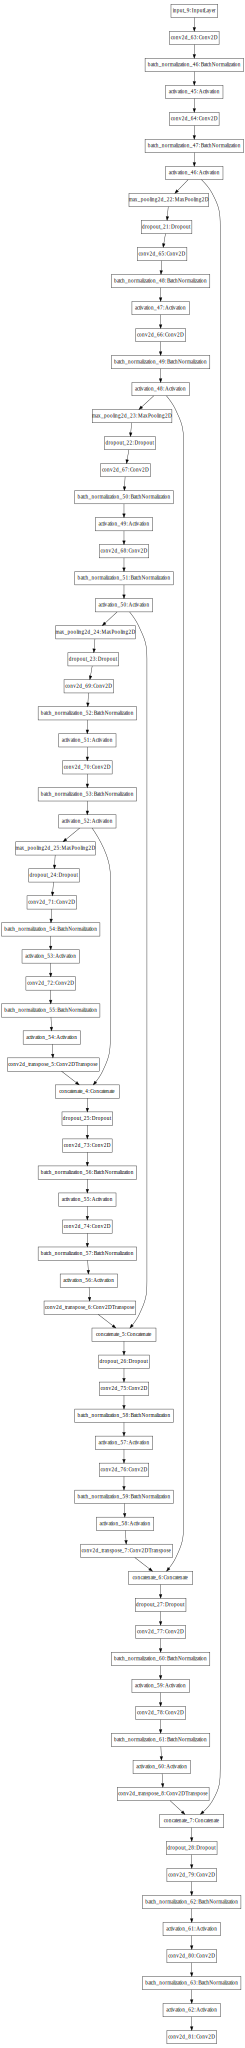

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(unet).create(prog='dot', format='svg'))

In [44]:
import cv2
X = [cv2.resize(imageio.imread(x), (224, 224)) for x in glob.glob('data/portrait/*_x.jpg')]
Y = [cv2.resize(imageio.imread(y), (224, 224)) for y in glob.glob('data/portrait/*_y.jpg')]

In [45]:
split = int(len(X) * 0.1)
train_x = np.array(X[:-split])
train_y = np.expand_dims(np.array(Y[:-split]), axis=-1)

test_x = np.array(X[-split:])
test_y = np.expand_dims(np.array(Y[-split:]), axis=-1)

In [47]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1447, 224, 224, 3),
 (1447, 224, 224, 1),
 (160, 224, 224, 3),
 (160, 224, 224, 1))

In [53]:
unet.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=4, epochs=15)

Train on 1447 samples, validate on 160 samples
Epoch 1/15
1447/1447 [==============================] - 44s 31ms/step - loss: 0.4738 - acc: 0.7772 - val_loss: 0.3056 - val_acc: 0.8758
Epoch 2/15
1447/1447 [==============================] - 42s 29ms/step - loss: 0.3388 - acc: 0.8599 - val_loss: 0.2697 - val_acc: 0.8889
Epoch 3/15
1447/1447 [==============================] - 42s 29ms/step - loss: 0.3102 - acc: 0.8724 - val_loss: 0.2625 - val_acc: 0.8915
Epoch 4/15
1447/1447 [==============================] - 42s 29ms/step - loss: 0.2919 - acc: 0.8798 - val_loss: 0.2624 - val_acc: 0.8911
Epoch 5/15
1447/1447 [==============================] - 42s 29ms/step - loss: 0.2752 - acc: 0.8868 - val_loss: 0.2411 - val_acc: 0.9031
Epoch 6/15
1447/1447 [==============================] - 42s 29ms/step - loss: 0.2647 - acc: 0.8908 - val_loss: 0.2219 - val_acc: 0.9031
Epoch 7/15
1447/1447 [==============================] - 42s 29ms/step - loss: 0.2540 - acc: 0.8953 - val_loss: 0.2175 - val_acc: 0.9096
E

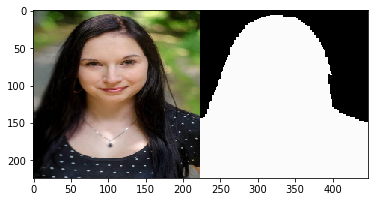

In [63]:
show(test_x[0], test_y[0].reshape((224, 224)))

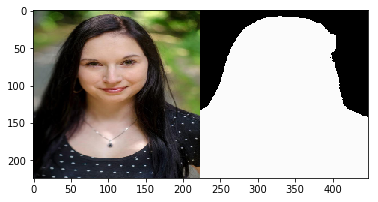

In [67]:
idx = 0
show(test_x[idx], unet.predict(np.expand_dims(test_x[idx], 0))[0].reshape((224, 224)) > 0.5)

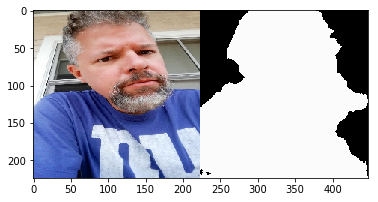

In [68]:
idx = 1
show(test_x[idx], unet.predict(np.expand_dims(test_x[idx], 0))[0].reshape((224, 224)) > 0.5)

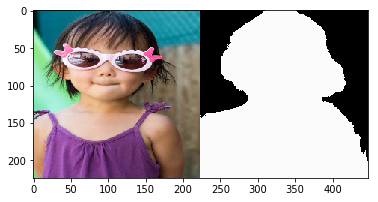

In [69]:
idx = 2
show(test_x[idx], unet.predict(np.expand_dims(test_x[idx], 0))[0].reshape((224, 224)) > 0.5)

In [77]:
unet.save_weights('weights/portrait.h5')

# Colorization

* 흑백 이미지를 넣으면 칼라 이미지를 출력해주는 network

### Motivation

* AE 구조와 U-net을 통한 segmentation을 보면 다음과 같은 생각이 들 수 있음
* X에 흑백 사진을 넣고, Y에 칼라 사진을 넣은담에 backprop 하면 흑백 이미지가 칼라로 변환 되는 것 아니야?
* 실제 colorization은 비슷한 동기를 가지고 시작됨

<center><img src='img/12_07.png' height=100% width=100%></center>

# 바로 시작

* 논문을 볼 것도 없음
* u-net구조에서 input channel이 3, output channel이 1이 었던 것을 반대로
* input channel 1, output channel 3으로,
* x의 데이터를 h x w x 1, y의 데이터를 h x w x 3으로 변경

In [79]:
def unet_color():
    inputs = Input((224, 224, 1))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2, 2)) (c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2, 2)) (c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2, 2)) (c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 3, strides=2, padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 3, strides=2, padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 3, strides=2, padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 3, strides=2, padding='same') (c8)
    #u9 = concatenate([u9, c1], axis=3)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [105]:
from skimage.color import rgb2gray
X = [cv2.resize(imageio.imread(x), (224, 224)) for x in glob.glob('data/portrait/*_x.jpg')]
Y = [rgb2gray(img) for img in X]
X, Y =  Y, X

In [107]:
split = int(len(X) * 0.1)
train_x = np.expand_dims(np.array(X[:-split]), -1)
train_y = np.array(Y[:-split])/255.

test_x = np.expand_dims(np.array(X[-split:]), -1)
test_y = np.array(Y[-split:])/255.

In [94]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1447, 224, 224, 1),
 (1447, 224, 224, 3),
 (160, 224, 224, 1),
 (160, 224, 224, 3))

In [ ]:
color_model = unet_color()
color_model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=4, epochs=15)

In [109]:
color_model.save_weights('weights/color_rgb.h5')

In [121]:
def show_both(idx):
    y = train_y[idx]
    p = color_model.predict(np.expand_dims(train_x[idx], axis=0))[0]
    plt.imshow(np.hstack([y, p]))
    plt.show()

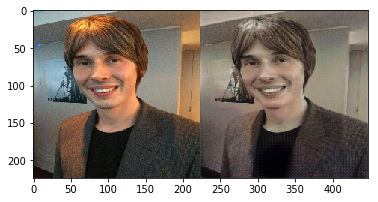

In [122]:
show_both(0)

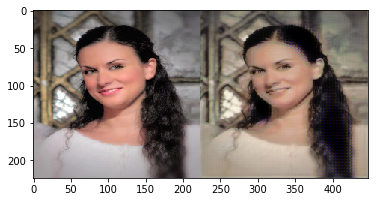

In [123]:
show_both(1)

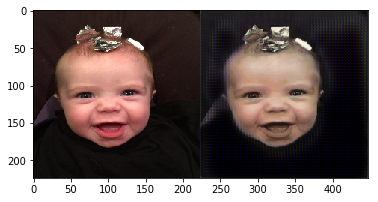

In [128]:
show_both(2)

# 개선 사항 고민
* 안된 것 같지는 않지만 잘된 것 같지도 않음
* 논문을 봐보자
* 구조는 크게 다른 것 같지 않지만 다른점이 하나있음

<center><img src='img/12_08.png' height=100% width=100%></center>

# Domain-knowledge (RGB)

* grayscale에서 RGB를 예측하는 것은 주어진 1개의 수에서 같은 스케일의 숫자 3개를 구하는 것
* 주어진 숫자 자체도 변화하는 R G B 색과 아주 큰 상관관계가 있지는 않음
* grayscale에서 RGB를 바로 예측하는 것은 어려운 문제
<center><img src='img/12_09.png' height=100% width=100%></center>

# LAB Color
* 색을 표현하는 방법은 RGB 뿐만이 아닌 여러가지 방식이 있음
* 그 중 Lab color는 해당 문제를 풀기에 RGB보다 적합해 보암
* Lab는 RGB와는 다르게 L (밝기) + a(green to magenta) + b(blue to yellow)로 색을 표현하는 방법
* 그중 L은 gray scale로 표현 될 수 있음
* 우리는 주어진 L과 a, b를 예측하는 문제로 기존 색상 3개를 예측하는 문제에서 색상 2개를 예측하는 문제로 변환

<center><img src='img/12_10.png' height=100% width=100%></center>

In [130]:
from skimage.color import rgb2lab
X = [rgb2lab(cv2.resize(imageio.imread(x), (224, 224))) for x in glob.glob('data/portrait/*_x.jpg')]

In [131]:
l = X[0][...,0]
a = X[0][...,1]
b = X[0][...,2]

In [132]:
print( np.min(l), np.max(l))
print( np.min(a), np.max(a))
print( np.min(b), np.max(b))

0.7048512553948889 93.93825933022188
-13.246054437482059 42.649665339581425
-78.13332648002165 62.0049241215106


In [134]:
X_norm = (np.array(X) + [0, 128, 128]) / [100., 255., 255.]
l = X_norm[0][...,0]
a = X_norm[0][...,1]
b = X_norm[0][...,2]

print( np.min(l), np.max(l))
print( np.min(a), np.max(a))
print( np.min(b), np.max(b))

0.007048512553948889 0.9393825933022188
0.450015472794188 0.6692143738807115
0.19555558243128765 0.7451173494961201


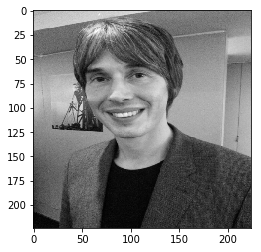

In [135]:
plt.imshow(l, cmap='gray')
plt.show()

In [141]:
X = X_norm[...,0]
Y = X_norm[...,1:]

In [142]:
def unet_lab():
    inputs = Input((224, 224, 1))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2, 2)) (c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2, 2)) (c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2, 2)) (c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 3, strides=2, padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 3, strides=2, padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 3, strides=2, padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 3, strides=2, padding='same') (c8)
    #u9 = concatenate([u9, c1], axis=3)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)
    
    outputs = Conv2D(2, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [143]:
split = int(len(X) * 0.1)
train_x = np.expand_dims(X[:-split], -1)
train_y = Y[:-split]

test_x = np.expand_dims(X[-split:], -1)
test_y = Y[-split:]

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1447, 224, 224, 1),
 (1447, 224, 224, 2),
 (160, 224, 224, 1),
 (160, 224, 224, 2))

In [144]:
lab_model = unet_lab()
lab_model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=4, epochs=15)

Train on 1447 samples, validate on 160 samples
Epoch 1/15
1447/1447 [==============================] - 52s 36ms/step - loss: 0.7068 - acc: 0.0000e+00 - val_loss: 0.6974 - val_acc: 0.0000e+00
Epoch 2/15
1447/1447 [==============================] - 46s 32ms/step - loss: 0.6921 - acc: 0.0000e+00 - val_loss: 0.6924 - val_acc: 0.0000e+00
Epoch 3/15
1447/1447 [==============================] - 46s 32ms/step - loss: 0.6918 - acc: 0.0000e+00 - val_loss: 0.6918 - val_acc: 0.0000e+00
Epoch 4/15
1447/1447 [==============================] - 46s 32ms/step - loss: 0.6916 - acc: 0.0000e+00 - val_loss: 0.6916 - val_acc: 0.0000e+00
Epoch 5/15
1447/1447 [==============================] - 46s 32ms/step - loss: 0.6915 - acc: 0.0000e+00 - val_loss: 0.6914 - val_acc: 0.0000e+00
Epoch 6/15
1447/1447 [==============================] - 46s 32ms/step - loss: 0.6914 - acc: 0.0000e+00 - val_loss: 0.6914 - val_acc: 0.0000e+00
Epoch 7/15
1447/1447 [==============================] - 46s 32ms/step - loss: 0.6913 - ac

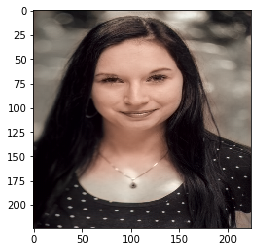

In [150]:
from skimage.color import lab2rgb

def l2rgb(l):
    pred_ab = lab_model.predict(np.expand_dims(l, 0))
    pred_img = np.zeros((224, 224, 3))
    pred_img[:,:,0] = l.reshape((224, 224))
    pred_img[:,:,1:] = pred_ab[0]
    
    pred_img = (pred_img * [100, 255, 255]) - [0, 128, 128]
    pred_img = lab2rgb(pred_img)
    return pred_img


plt.imshow(l2rgb(test_x[0]))
plt.show()

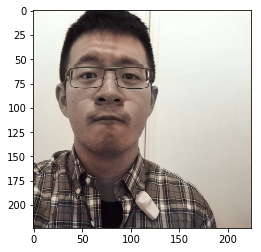

In [153]:
plt.imshow(l2rgb(test_x[3]))
plt.show()

In [154]:
lab_model.save_weights('weights/color_lab.h5')